## CHEME 5660 Example: Markowitz Portfolio Allocation with Risky and Risk-free Assets

### Introduction
The Markowitz allocation problem for a portfolio $\mathcal{P}$ composed of __only__ risky assets is the [quadratic program](https://en.wikipedia.org/wiki/Quadratic_programming):

$$\min_{w} \sigma^{2}_{\mathcal{P}}\left(w\right)$$

subject to the constraints:

$$
\begin{eqnarray}
\mathbb{E}(r_{\mathcal{P}})&\geq&{R^{*}}\\
1^{T}w &=& 1\\
w_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray}
$$

where $w$ denotes the vector of weights of the assets in portfolio $\mathcal{P}$, $\sigma^{2}_{\mathcal{P}}\left(w\right)$ represents the portfolio variance; the portfolio variance can re-written as $\sigma^{2}_{\mathcal{P}}\left(w\right) = w^{T}\Sigma{w}$  where $\Sigma$ is the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix). The quantity $\mathbb{E}(r_{\mathcal{P}})$ denotes the expected return (or excess return) of the portfolio $\mathcal{P}$; the expected return (or excess return) can be re-written as $w^{T}\mathbb{E}(r)$ where $\mathbb{E}(r)$ denotes the vector of expected returns (or excess returns) for each asset in the portfolio. 

The quantity $R^{*}$ denotes the minimal required return for $\mathcal{P}$, and $1^{T}$ represents a vector of ones (total allocation constraint). The last constraint $w_{i}\geq{0}~\forall{i}\in\mathcal{P}$ says that no short selling (borrowing shares) is allowed; if short selling is allowed, then this constraint can be removed.

#### Risk-free case
If we include risk-free assets in the portfolio, then the reward constraint is replaced by:

$$\left(1-\sum_{a\in\mathcal{A}}\omega_{a}\right)r_{f}+\mathbb{E}(r_{\mathcal{P}})\geq{R^{*}}$$

where $r_{f}$ denotes the risk-free rate of return. 

### Example setup
The code block below installs (and loads) any [Julia](https://julialang.org) packages that we need to complete the calculations.

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-markowitz-notebook`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-markowitz-notebook/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-markowitz-notebook/Manifest.toml`


In [2]:
# load req packages -
using Convex
using SCS
using DataFrames
using CSV
using Dates
using Colors
using Plots
using Statistics
using MathOptInterface
using FileIO
using JLD2
using PrettyTables

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

In [3]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# how many days to we want to look at?
m = 200;

### Load the example code library
The call to the `include` function loads the `Example-Markowitz-CodeLib.jl` library into the notebook; the library contains types and functions we use during the lab:

__Functions__:
* `compute_minvar_portfolio_allocation --> Tuple` and `compute_minvar_portfolio_allocation_risk_free --> Tuple` compute the optimum (minimum) risk given a specified reward for risky and risky+risk-free portfolios. 
* `compute_fractional_return_array --> DataFrame` computes the fractional return for a firm $i$
* `compute_covariance_array --> Array{Float64,2}` computes the covariance matrix $\Sigma$ from the return values.

In [4]:
include("Example-Markowitz-CodeLib.jl");

### a) Load the historical data set
The historical data set was downloaded using the [RESTful Application Programming Interface of Polygon.io](https://polygon.io) using the [PQPolygonSDK.jl](https://github.com/Paliquant/PQPolygonSDK.jl) package. The data contains daily Open High Low Close (OHLC) data for N = 100 stocks for the last two-years.

In [5]:
# load the JLD2 portfolio data file -
price_data_dictionary = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"];

In [6]:
price_data_dictionary

Dict{String, DataFrame} with 100 entries:
  "BLK"  => 597×8 DataFrame…
  "TGT"  => 597×8 DataFrame…
  "VZ"   => 597×8 DataFrame…
  "C"    => 597×8 DataFrame…
  "SPY"  => 597×8 DataFrame…
  "SPYV" => 597×8 DataFrame…
  "CVS"  => 597×8 DataFrame…
  "VTI"  => 597×8 DataFrame…
  "CSCO" => 597×8 DataFrame…
  "IBM"  => 597×8 DataFrame…
  "HD"   => 597×8 DataFrame…
  "AMGN" => 597×8 DataFrame…
  "UNP"  => 597×8 DataFrame…
  "SBUX" => 597×8 DataFrame…
  "VWO"  => 597×8 DataFrame…
  "AIG"  => 597×8 DataFrame…
  "WMT"  => 597×8 DataFrame…
  "PEP"  => 597×8 DataFrame…
  "MS"   => 597×8 DataFrame…
  "K"    => 597×8 DataFrame…
  "CPB"  => 597×8 DataFrame…
  "BA"   => 597×8 DataFrame…
  "CLX"  => 597×8 DataFrame…
  "JPM"  => 597×8 DataFrame…
  "MRNA" => 597×8 DataFrame…
  ⋮      => ⋮

In [7]:
# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);
Nₐ = length(ticker_symbol_array);

### b) Compute the fractional return
Let the close price of `XYZ` on day $j$ be given by $P_{j}$. Then, the fractional return $r_{j,j-1}$ between day $j-1\rightarrow{j}$ is given by:

$$r_{j,j-1} = \frac{P_{j} - P_{j-1}}{P_{j-1}}$$

In [8]:
# compute the returns -
return_data_dictionary = Dict{String,DataFrame}();
for ticker_symbol ∈ ticker_symbol_array

    # Serenity -> computes the log return given a DataFrame, returns a DataFrame
    return_data_dictionary[ticker_symbol] = compute_fractional_return_array(price_data_dictionary[ticker_symbol];
    m = m, rf = risk_free_daily)
end

### c) Compute the mean-return vector $\mu$ and the covariance array $\Sigma$

The mean-return vector $\mu$ is a $N\times{1}$ vector that holds the mean of the fractional return values for each ticker in the data set. The covariance matrix $\Sigma$ whose $(i,j)$ element is given by:

$$\Sigma_{ij} = \sigma_{i}\sigma_{j}\rho_{ij}$$

is calculated from the standard deviation of the fractional return values for a firm $k$, while $\rho_{ij}$ is the correlation between the returns of firm $i$ and $j$.

In [9]:
# compute the cov -
Σ = compute_covariance_array(ticker_symbol_array, return_data_dictionary);
μ_vector = compute_mean_return_array(ticker_symbol_array, return_data_dictionary);

### d) Compute the efficient frontier for a portfolio of risky assets (N = 100)

#### Calculation

In [10]:
# define the returns that we are going to simulate -
target_return_array = 100 .* (range(0.0, step=0.0001, stop = 0.004) |> collect) # percentage
L = length(target_return_array)

# Initialize MinVar array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarArray = Array{Float64,2}(undef,L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation(μ_vector, Σ, tr; w_lower = 0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        MinVarArray[i,1] = opt_val;
        MinVarArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarArray[i,2+a] = ω[a]
        end
    end
end

In [11]:
L

41

#### Visualize

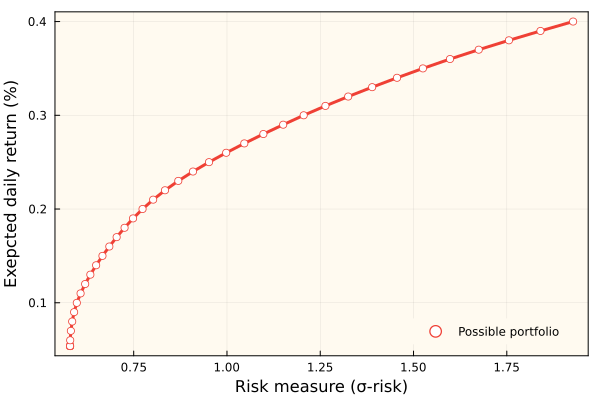

In [12]:
# pull out the risk and rerturn -
risk_array = sqrt.(MinVarArray[:,1])
return_array = MinVarArray[:,2];

# plot -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3)
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")
xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted daily return (%)", fontsize=18)

In [13]:
# make a allocation table for risky asset *only* case -

# what portfolio index do we need?
portfolio_index = 41;
δ = 0.01; # what is my cutoff?

# find the indexes of the assets that are "not small" -
idx_not_small = findall(x-> abs(x) >= δ, MinVarArray[portfolio_index,3:end])
A = length(idx_not_small);

# setup table -
allocation_table_data = Array{Any,2}(undef, A+1, 4);
for a ∈ 1:A
    
    # grab the data -
    idx = idx_not_small[a];
    ticker = ticker_symbol_array[idx]
    ωₐ = MinVarArray[portfolio_index,(idx .+ 2)];

    # package -
    allocation_table_data[a,1] = ticker;
    allocation_table_data[a,2] = ωₐ
    allocation_table_data[a,3] = μ_vector[idx];
    allocation_table_data[a,4] = Σ[idx,idx];
end

# add a total row -
allocation_table_data[end,1] = "Total"
allocation_table_data[end,2] = sum(allocation_table_data[1:A,2])
allocation_table_data[end,3] = MinVarArray[portfolio_index,2];
allocation_table_data[end,4] = sqrt.(MinVarArray[portfolio_index,1])

# header -
allocation_table_header = (["Ticker", "weight", "E(r)", "var"])

# show the table -
pretty_table(allocation_table_data; header = allocation_table_header)

┌────────┬───────────┬───────────┬─────────┐
│ Ticker │    weight │      E(r) │     var │
├────────┼───────────┼───────────┼─────────┤
│    AMD │  0.173604 │  0.465808 │ 15.8404 │
│    BIO │  0.114664 │  0.342851 │ 7.04673 │
│   NFLX │ 0.0263909 │  0.424057 │ 31.5246 │
│    SWK │  0.546509 │  0.477961 │ 7.89456 │
│    VXX │  0.138833 │ 0.0534446 │   14.43 │
│  Total │       1.0 │       0.4 │  1.9277 │
└────────┴───────────┴───────────┴─────────┘


### c) Compute the efficient frontier for a portfolio of risky assets (N = 100) and a single risk-free asset

#### Calculation

In [14]:
# Initialize MinVarRiskFree array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarRiskFreeArray = Array{Float64,2}(undef,L, (Nₐ + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, ω, opt_val, ret_val) = compute_minvar_portfolio_allocation_risk_free(μ_vector, Σ, tr, risk_free_daily; 
        w_lower = 0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        # capture the risk and reward values -
        MinVarRiskFreeArray[i,1] = opt_val;
        MinVarRiskFreeArray[i,2] = ret_val;
        
        # capture the allocation
        for a ∈ 1:Nₐ
            MinVarRiskFreeArray[i,2+a] = ω[a]
        end
    end
end

#### Visualize

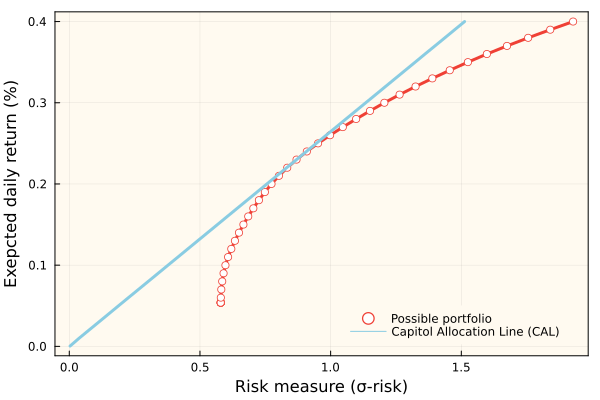

In [15]:
# pull out the risk and rerturn for the risk-free case -
risk_array_rf = sqrt.(MinVarRiskFreeArray[:,1])
return_array_rf = MinVarRiskFreeArray[:,2];

# plot the risk-only portfolio -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3)
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")

# plot the CAL -

plot!(risk_array_rf,  return_array_rf, lw=3, c=colorant"#89CCE2", label="Capitol Allocation Line (CAL)")

# axis labels -
xlabel!("Risk measure (σ-risk)", fontsize=18)
ylabel!("Exepcted daily return (%)", fontsize=18)

In [16]:
# make a allocation table for risky+risk free asset case -

# what portfolio index do we need?
portfolio_index_rf = findall(x->x<=0.90, risk_array_rf)[end]
δ = 0.005; # what is my cutoff?

# find the indexes of the assets that are "not small" -
idx_not_small_rf = findall(x-> abs(x) >= δ, MinVarRiskFreeArray[portfolio_index_rf,3:end])
A = length(idx_not_small_rf);

# setup table -
allocation_table_data_rf = Array{Any,2}(undef, A + 1, 4);
for a ∈ 1:A
    
    # grab the data -
    idx = idx_not_small_rf[a];
    ticker = ticker_symbol_array[idx]
    ωₐ = MinVarRiskFreeArray[portfolio_index,(idx .+ 2)];

    # package -
    allocation_table_data_rf[a,1] = ticker;
    allocation_table_data_rf[a,2] = ωₐ
    allocation_table_data_rf[a,3] = μ_vector[idx];
    allocation_table_data_rf[a,4] = Σ[idx,idx];
end

# add a total row -
allocation_table_data_rf[end,1] = "Total"
allocation_table_data_rf[end,2] = sum(MinVarRiskFreeArray[portfolio_index_rf, (idx_not_small_rf .+ 2)])
allocation_table_data_rf[end,3] = MinVarRiskFreeArray[portfolio_index_rf,2];
allocation_table_data_rf[end,4] = sqrt.(MinVarRiskFreeArray[portfolio_index_rf,1])

# header -
allocation_table_header_rf = (["Ticker", "weight", "E(r)", "var"])

# show the table -
pretty_table(allocation_table_data_rf; header = allocation_table_header_rf)

┌────────┬───────────┬───────────┬──────────┐
│ Ticker │    weight │      E(r) │      var │
├────────┼───────────┼───────────┼──────────┤
│    AMD │ 0.0643286 │  0.465808 │  15.8404 │
│    BIO │  0.139064 │  0.342851 │  7.04673 │
│    FDX │ 0.0377612 │  0.267445 │  9.28411 │
│   INTC │  0.123953 │  0.345549 │  6.13052 │
│   NFLX │ 0.0323774 │  0.424057 │  31.5246 │
│    SWK │   0.20314 │  0.477961 │  7.89456 │
│      T │ 0.0708673 │  0.195531 │  5.77745 │
│    VWO │  0.386519 │  0.181731 │  2.02638 │
│    VXX │  0.361011 │ 0.0534446 │    14.43 │
│     VZ │  0.308535 │  0.175631 │  2.30875 │
│  Total │  0.993158 │      0.23 │ 0.869525 │
└────────┴───────────┴───────────┴──────────┘


### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.